In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Debernardi et al 2020 data.csv')

In [3]:
df.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [4]:
df.isna().sum()

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

In [5]:
df.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


# Handling NAN values

In [6]:
feature_na=[feature for feature in df.columns if df[feature].isnull().sum()>0]

In [7]:
del(df['stage'])
del(df['benign_sample_diagnosis'])
del(df['sample_id'])

In [8]:
df = df.interpolate()

In [9]:
df.isna().sum()

patient_cohort    0
sample_origin     0
age               0
sex               0
diagnosis         0
plasma_CA19_9     0
creatinine        0
LYVE1             0
REG1B             0
TFF1              0
REG1A             0
dtype: int64

In [10]:
df['sex'].value_counts()

F    299
M    291
Name: sex, dtype: int64

In [11]:
df['sex'] = df['sex'].map({'M': 1, 'F': 0})
df['sex'] = pd.to_numeric(df['sex'], errors='coerce')

In [12]:
df['sex'].value_counts()

0    299
1    291
Name: sex, dtype: int64

In [13]:
df['patient_cohort'] = df['patient_cohort'].map({'Cohort1': 1, 'Cohort2': 0})
df['patient_cohort'] = pd.to_numeric(df['patient_cohort'], errors='coerce')

In [14]:
df['patient_cohort'].value_counts()

1    332
0    258
Name: patient_cohort, dtype: int64

In [15]:
df['sample_origin'] = df['sample_origin'].map({'BPTB': 0, 'LIV': 1,'ESP': 2,'UCL': 3})
df['sample_origin'] = pd.to_numeric(df['sample_origin'], errors='coerce')

In [16]:
df["sample_origin"].value_counts()

0    409
1    132
2     29
3     20
Name: sample_origin, dtype: int64

In [17]:
target='diagnosis'
x = df.drop(target, axis=1)
y = df[target]

In [18]:
#Spliting dataset into training set and testing test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [19]:
# Feature selection
from sklearn.feature_selection import chi2
fscore = chi2(X_train, y_train) # to avoid overfitting by leaking the info to the model
fscore
pvalues = pd.Series(fscore[1])
pvalues.index = X_train.columns
pvalues
pvalues.sort_values(ascending=False)

creatinine         1.632496e-01
sex                7.594085e-02
patient_cohort     5.095998e-06
sample_origin      1.036463e-22
age                2.447569e-44
LYVE1             9.188756e-141
plasma_CA19_9      0.000000e+00
REG1B              0.000000e+00
TFF1               0.000000e+00
REG1A              0.000000e+00
dtype: float64

In [20]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

accuracy_max = 0
rate_max = 0

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)
    
    tr = gb_clf.score(X_train, y_train)
    tv = gb_clf.score(X_test, y_test)
    
    if tv > accuracy_max:
        accuracy_max = tv
        rate_max = learning_rate
    
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(tr))
    print("Accuracy score (validation): {0:.3f}".format(tv))
    
print("Maximum accuracy = ", accuracy_max, "at ", rate_max)


Learning rate:  0.05
Accuracy score (training): 0.896
Accuracy score (validation): 0.831
Learning rate:  0.075
Accuracy score (training): 0.909
Accuracy score (validation): 0.822
Learning rate:  0.1
Accuracy score (training): 0.941
Accuracy score (validation): 0.822
Learning rate:  0.25
Accuracy score (training): 0.981
Accuracy score (validation): 0.831
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.839
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.847
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.847
Maximum accuracy =  0.847457627118644 at  0.75


In [25]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train)
tv = gb_clf.score(X_test, y_test)
pred_y = gb_clf.predict(X_test)


# Confusion matrix
from sklearn import metrics
confusion = metrics.confusion_matrix(y_test,pred_y)
print(confusion)

[[27  4  0]
 [ 7 36  1]
 [ 1  5 37]]


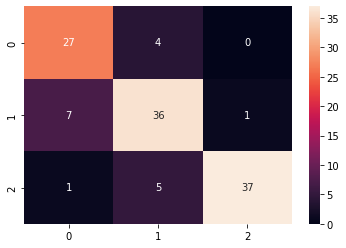

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_y)
f = sns.heatmap(cm, annot=True, fmt='d')

In [27]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_test, pred_y, average='macro')

0.8498715587987906

In [28]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_test, pred_y, average='macro')

0.8483709273182959

In [29]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_test, pred_y, average='macro')

0.8469169430467808

In [30]:
# Classification report
from sklearn.metrics import classification_report
# classification_report(y_test, pred_y)
target_names = ['healthy', 'non-PDAC', 'PDAC']
print(f'Classification Report: \n{classification_report(y_test, pred_y, target_names=target_names)}\n')
print("")

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy = ", accuracy_score(y_test, pred_y))

Classification Report: 
              precision    recall  f1-score   support

     healthy       0.77      0.87      0.82        31
    non-PDAC       0.80      0.82      0.81        44
        PDAC       0.97      0.86      0.91        43

    accuracy                           0.85       118
   macro avg       0.85      0.85      0.85       118
weighted avg       0.86      0.85      0.85       118



Accuracy =  0.847457627118644


In [31]:
# Specificity
# code it based on the confusion matrix

# Class - 1
sp1 = (cm[1,1]+cm[2,2])/(cm[1,0]+cm[2,0]+cm[1,1]+cm[2,2])
# Class - 2
sp2 = (cm[0,0]+cm[2,2])/(cm[0,1]+cm[2,1]+cm[0,0]+cm[2,2])
# Class - 3
sp3 = (cm[0,0]+cm[1,1])/(cm[0,2]+cm[1,2]+cm[0,0]+cm[1,1])

print(sp1, sp2, sp3)

0.9012345679012346 0.8767123287671232 0.984375
